# Explore results after scraping results website

### User variables


In [1]:
Date = '2019-10' # yyyy-mm

### Modules and functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,Image

### Load results

Load auction results and data from rdw.

In [3]:
file_name = '../data/drz-data-{}.pkl'.format(Date)
print(file_name)
drz = pd.read_pickle(file_name)
file_name = '../data/rdw-data-{}.pkl'.format(Date)
print(file_name)
rdw = pd.read_pickle(file_name)

# rdw column names
#   NOTE: format changed in April 2019: RDW info is appended to auction results as extra columns in dataframe
if pd.to_datetime(Date, format='%Y-%m') >= pd.to_datetime('2019-04', format='%Y-%m'):
    rdwinfo = [c for c in rdw.columns if c.startswith('rdw_')]

# fix odometer
if pd.to_datetime(Date, format='%Y-%m') == pd.to_datetime('2019-09', format='%Y-%m'):
    sel = (rdw.OdoKM == 'volgens NAP logisch') | (rdw.OdoKM == 'volgens NAP onlogisch') | (rdw.OdoKM == 'volgens nap onlogisch')
    display(drz.loc[sel, ['Title', 'OdoKM', 'NAP']])
    
    idx = '2019-9-9106'
    print('\n'.join(drz.loc[idx,'Raw_text']))
    drz.loc[idx,'NAP'] = 'logisch'
    rdw.loc[idx,'NAP'] = 'logisch'
    drz.loc[idx,'OdoKM'] = '251.571'
    rdw.loc[idx,'OdoKM'] = '251.571'
    
    display(drz.loc[[idx],['Title', 'OdoKM', 'NAP']])
    display(rdw.loc[[idx],['Title', 'OdoKM', 'NAP']])

    idx = '2019-9-9258'
    print('\n'.join(drz.loc[idx,'Raw_text']))
    drz.loc[idx,'NAP'] = 'onlogisch'
    rdw.loc[idx,'NAP'] = 'onlogisch'
    drz.loc[idx,'OdoKM'] = ''
    rdw.loc[idx,'OdoKM'] = ''
    
    idx = '2019-9-9249'
    print('\n'.join(drz.loc[idx,'Raw_text']))
    drz.loc[idx,'NAP'] = 'onlogisch'
    rdw.loc[idx,'NAP'] = 'onlogisch'
    drz.loc[idx,'OdoKM'] = ''
    rdw.loc[idx,'OdoKM'] = ''
    
    
    display(rdw.loc[sel, ['Title', 'OdoKM', 'NAP']])
    display(drz.loc[sel, ['Title', 'OdoKM', 'NAP']])
    sel = (rdw.OdoKM == 'volgens NAP logisch') | (rdw.OdoKM == 'volgens NAP onlogisch')
    assert all(~sel)



../data/drz-data-2019-10.pkl
../data/rdw-data-2019-10.pkl


# Cheap cars with valid inspection

In [ ]:
is_cheap = (
    drz.LotType == "Personenauto"
) & (
    drz.Price<3000
) & (
    drz.Price>0
) & ~(
    (
        drz.APKdate.isnull()
    ) | (
        drz.APKdate.apply(lambda x:x == '')
    )
)

drz.loc[is_cheap,
        ["Price","ItemType","ItemBrand","Mfdate","APKdate","OdoKM"]].sort_values(by='OdoKM')

In [ ]:
if pd.to_datetime(Date, format='%Y-%m') < pd.to_datetime('2019-04', format='%Y-%m'):
    display(rdw.loc[is_cheap,["rdwinfo"]])
else:
    display(rdw.loc[is_cheap,rdwinfo])

In [ ]:
if pd.to_datetime(Date, format='%Y-%m') < pd.to_datetime('2019-04', format='%Y-%m'):
    display(rdw.loc[is_cheap,"rdwinfo"][0])
else:
    display(rdw.loc[is_cheap,rdwinfo].iloc[0,:])

# Pictures of lots

In [ ]:
# ix=drz.N_images.idxmax()
ix=drz.Price.idxmax(); print('Price: EUR {:g}\n\n'.format(drz.loc[ix,'Price']))
# Mfdate = drz.Mfdate.apply(lambda x: pd.to_datetime(x,format='%d.%m.%Y') if len(x)==10 else pd.np.NaN)
# ix=Mfdate.idxmin(); print('year of mf: {:s}\n\n'.format(drz.loc[ix,'Mfdate']))
# ix = '2019-2-2005' # largest km/day
# ix = '2019-2-7345' # largest km

print(ix)
for u in drz.loc[ix,'Images']:
    print(u)
    print(drz.loc[ix,'Source'])
    display(Image(url=u,width=400))
    

# Usage

How many km are driven per year or day?

### Odometer conversion

In [8]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    df.OdoKM = df.OdoKM.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

In [ ]:
odo_str2float(drz)

drz[['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']]

### Dates

In [10]:
AuctDate = pd.to_datetime(drz.index[0][0:-5], format = '%Y-%m')

# serial date
drz["Mfdate_ser"] = drz.Mfdate.apply(lambda x:pd.to_datetime(x, format = '%d.%m.%Y') if (x!='') & ('-' not in x) else pd.np.NaN)

# age
drz["Age"] = (AuctDate - drz.Mfdate_ser)
drz["Age_year"] = drz.Age.apply(lambda x:x.days/365.25)

- - - -
# Continue with cars only

In [11]:
out = drz.Price.copy()
Features = drz.loc[:,["ItemBrand","ItemType","Odo","Age_year"]].copy()

In [12]:
# Drop rows
Subsel = drz.LotType == 'Personenauto'
dropIx=drz[~Subsel].index
out.drop(index=dropIx,inplace=True)
Features.drop(index=dropIx,inplace=True)

### one hot encoding brand and model

In [13]:
Dummies = pd.get_dummies(Features.ItemBrand,prefix='Brand_',drop_first=False)
Features = pd.concat([Features,Dummies],axis=1)

Features.describe()

,Odo,Age_year,Brand__AUDI,Brand__BMW,Brand__CHEVROLET,Brand__CHRYSLER,Brand__CITROËN,Brand__FIAT,Brand__FORD,Brand__HYUNDAI,...,Brand__NISSAN,Brand__OPEL,Brand__PEUGEOT,Brand__RENAULT,Brand__SEAT,Brand__SKODA,Brand__SUZUKI,Brand__TOYOTA,Brand__VOLKSWAGEN,Brand__VOLVO
count,102.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,198023.788887,12.150506,0.119266,0.073394,0.009174,0.009174,0.036697,0.027523,0.009174,0.009174,...,0.018349,0.064220,0.064220,0.064220,0.055046,0.009174,0.018349,0.036697,0.165138,0.055046
std,93580.334239,6.099488,0.325598,0.261987,0.095783,0.095783,0.188886,0.164357,0.095783,0.095783,...,0.134829,0.246277,0.246277,0.246277,0.229123,0.095783,0.134829,0.188886,0.373020,0.229123
min,10820.000000,1.656400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,139073.000000,8.501027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,191208.000000,12.440794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,254674.750000,15.017112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,443545.000000,44.588638,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Plotting

In [14]:
def ecdf(data):
    x = sorted(data)
    y = pd.np.arange(0,len(x))/len(x)
    return x,y

# # example
# x,y = ecdf(km_p_day)
# plt.plot(x,y)

In [15]:
# km per day
km_p_day = Features.Odo/(Features.Age_year*365.25).fillna(0)
sel = ~(km_p_day.isna() | (km_p_day == pd.np.inf))
km_p_day = km_p_day.loc[sel]

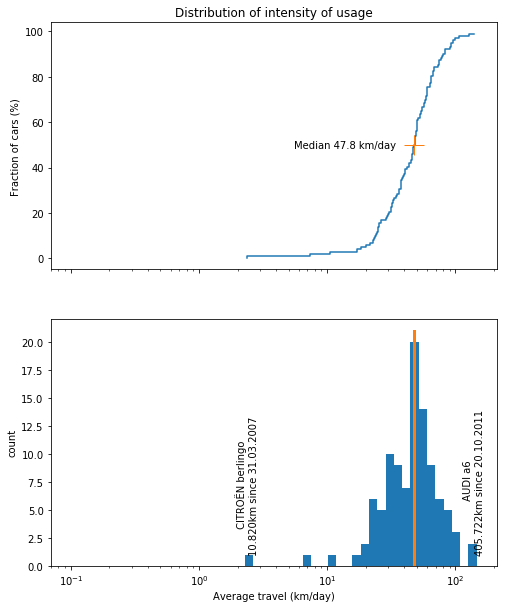

In [16]:
# Plot ecdf and hist
x,y = ecdf(km_p_day)
fig,axs = plt.subplots(ncols=1,nrows=2, figsize=[8,10],sharex=True)

# ecdf
ax = axs[0]
ax.step(x,y*100)
ax.plot(pd.np.median(x),50,'+',markersize=20)
ax.text(pd.np.median(x),50,'Median {:.1f} km/day      '.format(pd.np.median(x)),ha='right',va='center');
ax.set_title('Distribution of intensity of usage')
ax.set_ylabel('Fraction of cars (%)')

xl = axs[0].get_xlim()

# hist
ax = axs[1]
ax.hist(x,bins=pd.np.logspace(-1,pd.np.log10(xl[1]),50))
yl = axs[1].get_ylim()
ax.plot(pd.np.array([1,1])*pd.np.median(x),yl,'-',linewidth=3)
ax.set_xlabel('Average travel (km/day)')
ax.set_ylabel('count')

ax.text(
    km_p_day.min(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmin(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.text(
    km_p_day.max(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmax(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.set_xscale('log')


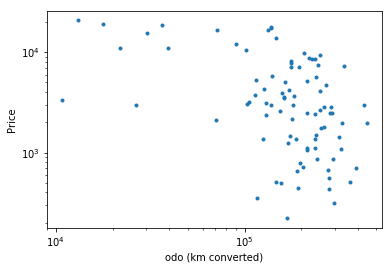

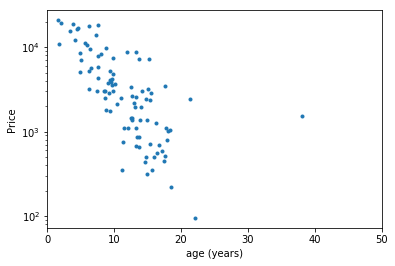

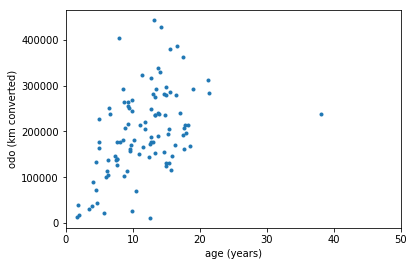

In [17]:
plt.plot(Features.Odo,out,'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('odo (km converted)')
plt.ylabel('Price')

plt.figure()
plt.plot(Features.Age_year,out,'.')
plt.yscale('log')
plt.xlabel('age (years)')
plt.ylabel('Price')
plt.xlim(0,50)


plt.figure()
plt.plot(Features.Age_year,Features.Odo,'.')
plt.xlabel('age (years)')
plt.ylabel('odo (km converted)')
plt.xlim(0,50)

plt.show()



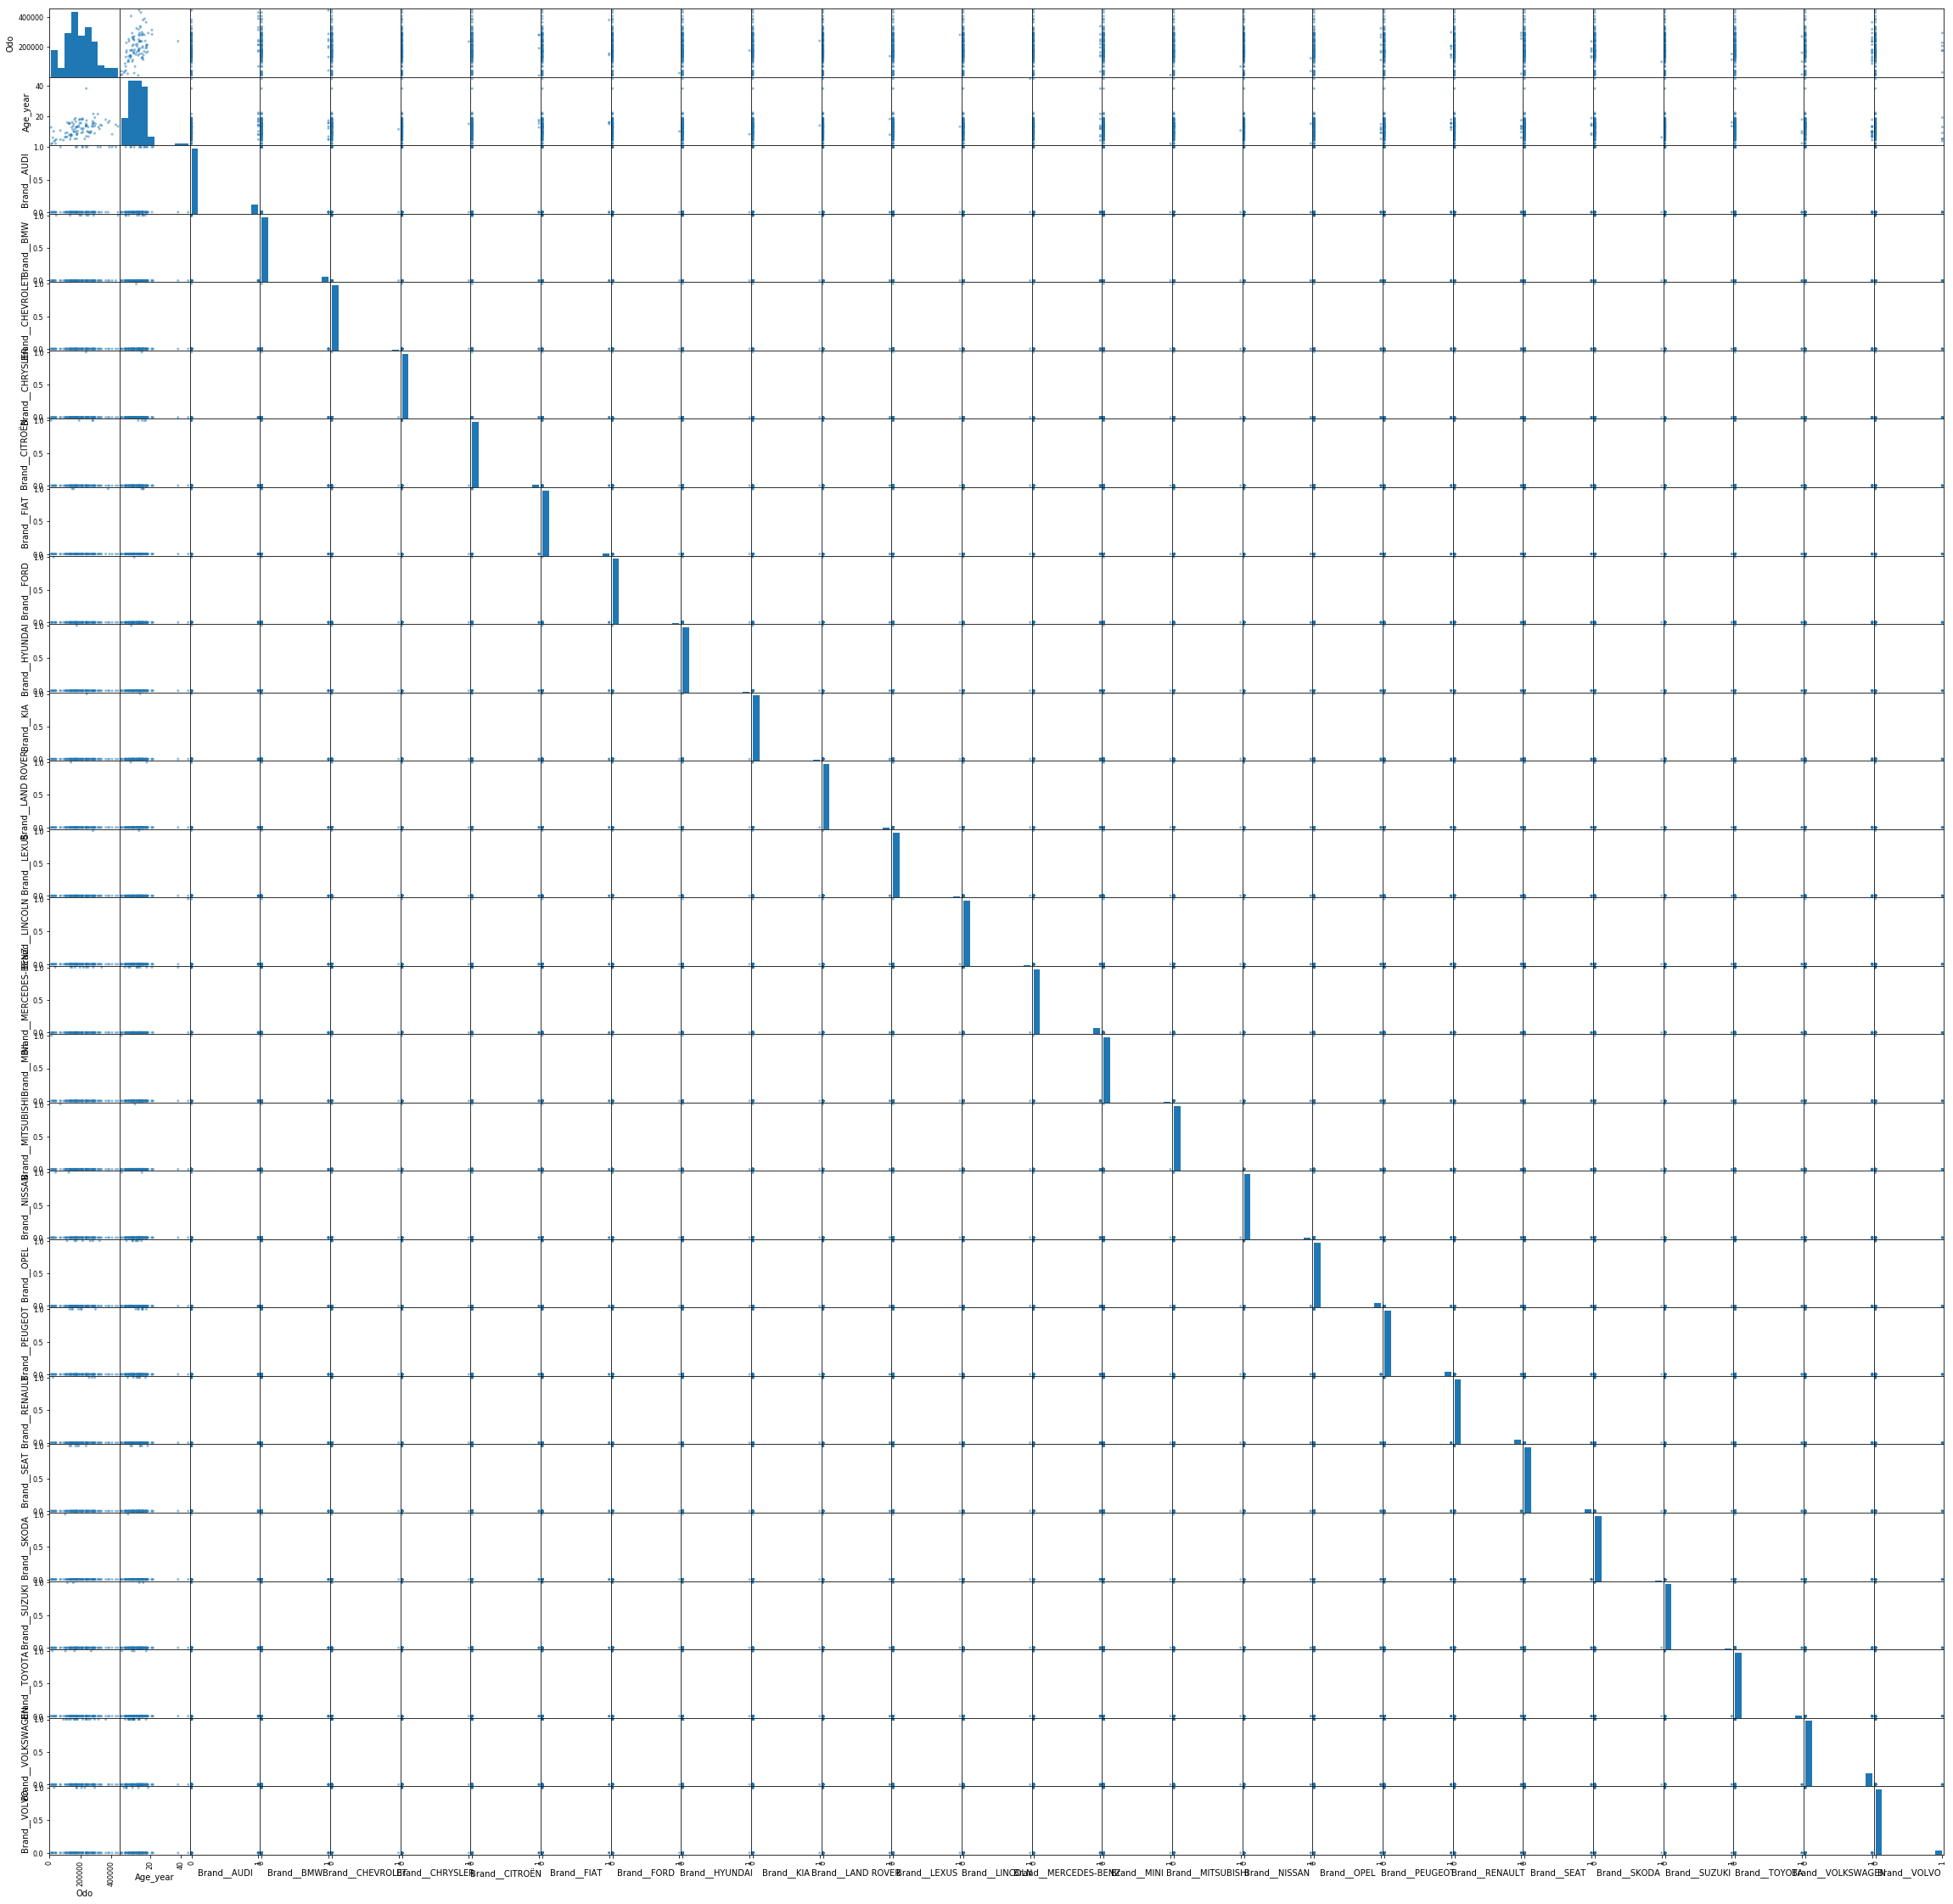

In [18]:
pd.plotting.scatter_matrix(Features,figsize=[40,40])
plt.show()